In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# 可选：安装lightgbm和xgboost获得更好性能
try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False
    print('LightGBM not installed')

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print('XGBoost not installed')

print('Libraries loaded!')

Libraries loaded!


## 1. 数据加载与预处理

In [22]:
# 加载数据
DATA_DIR = Path('.')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print(f'训练集: {train_df.shape}')
print(f'测试集: {test_df.shape}')

训练集: (9021, 98)
测试集: (10, 99)


In [23]:
# 定义特征和目标列
target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
id_col = 'date_id'

# 获取特征列
exclude_cols = [id_col] + target_cols
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f'特征数量: {len(feature_cols)}')

特征数量: 94


In [24]:
# 处理缺失值 - 找到数据相对完整的起始点
missing_by_date = train_df[feature_cols].isnull().sum(axis=1)
threshold = len(feature_cols) * 0.05  # 5%缺失值阈值

# 找到缺失值小于阈值的起始点
valid_mask = missing_by_date <= threshold
valid_start_idx = valid_mask.idxmax()
valid_start_date = train_df.loc[valid_start_idx, 'date_id']

print(f'数据完整起始点 date_id: {valid_start_date}')
print(f'使用的训练样本数: {(train_df["date_id"] >= valid_start_date).sum()}')

# 筛选数据
train_clean = train_df[train_df['date_id'] >= valid_start_date].copy().reset_index(drop=True)

数据完整起始点 date_id: 5540
使用的训练样本数: 3481


In [25]:
# 特征工程类
class FeatureEngineer:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='median')
        self.scaler = StandardScaler()
        self.feature_cols = None
        
    def fit(self, df, feature_cols):
        self.feature_cols = feature_cols
        X = df[feature_cols].values
        X_imputed = self.imputer.fit_transform(X)
        self.scaler.fit(X_imputed)
        return self
    
    def transform(self, df):
        X = df[self.feature_cols].values
        X_imputed = self.imputer.transform(X)
        X_scaled = self.scaler.transform(X_imputed)
        return X_scaled
    
    def fit_transform(self, df, feature_cols):
        self.fit(df, feature_cols)
        return self.transform(df)

In [26]:
# 准备训练数据
fe = FeatureEngineer()
X_train = fe.fit_transform(train_clean, feature_cols)
y_train = train_clean['forward_returns'].values

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (3481, 94)
y_train shape: (3481,)


## 2. 评估指标实现

In [27]:
# 实现竞赛评估指标
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

def calculate_adjusted_sharpe(forward_returns, risk_free_rate, positions):
    """
    计算波动率调整后的夏普比率
    
    Args:
        forward_returns: 远期收益率数组
        risk_free_rate: 无风险利率数组
        positions: 仓位权重数组 (0-2)
    
    Returns:
        adjusted_sharpe: 调整后的夏普比率
    """
    # 确保仓位在有效范围内
    positions = np.clip(positions, MIN_INVESTMENT, MAX_INVESTMENT)
    
    # 计算策略收益
    strategy_returns = risk_free_rate * (1 - positions) + positions * forward_returns
    
    # 计算策略超额收益
    strategy_excess_returns = strategy_returns - risk_free_rate
    strategy_excess_cumulative = np.prod(1 + strategy_excess_returns)
    n = len(strategy_returns)
    strategy_mean_excess_return = strategy_excess_cumulative ** (1 / n) - 1
    strategy_std = np.std(strategy_returns)
    
    if strategy_std == 0:
        return -np.inf
    
    trading_days_per_yr = 252
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    
    # 市场基准
    market_excess_returns = forward_returns - risk_free_rate
    market_excess_cumulative = np.prod(1 + market_excess_returns)
    market_mean_excess_return = market_excess_cumulative ** (1 / n) - 1
    market_std = np.std(forward_returns)
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    
    if market_volatility == 0:
        return -np.inf
    
    # 波动率惩罚
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    vol_penalty = 1 + excess_vol
    
    # 收益惩罚
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap ** 2) / 100
    
    # 调整后的夏普比率
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    
    return min(adjusted_sharpe, 1_000_000)

print('评估函数定义完成')

评估函数定义完成


## 3. 策略类实现

In [28]:
class TradingStrategy:
    """
    交易策略基类
    将预测转换为投资权重
    """
    def __init__(self, method='sigmoid'):
        self.method = method
        
    def predict_to_weight(self, predictions, volatility=None):
        """
        将收益预测转换为投资权重
        
        Args:
            predictions: 收益预测值
            volatility: 波动率估计（可选）
        
        Returns:
            weights: 投资权重 (0-2)
        """
        if self.method == 'sigmoid':
            # Sigmoid方法：将预测映射到0-2
            # 预测为正时weight > 1，预测为负时weight < 1
            scale = 100  # 缩放因子
            weights = 2 / (1 + np.exp(-scale * predictions))
            
        elif self.method == 'linear':
            # 线性方法：基于预测的分位数
            pct = (predictions - predictions.min()) / (predictions.max() - predictions.min() + 1e-8)
            weights = pct * 2
            
        elif self.method == 'threshold':
            # 阈值方法：预测>0则做多
            weights = np.where(predictions > 0, 1.5, 0.5)
            
        elif self.method == 'volatility_adjusted':
            # 波动率调整方法
            if volatility is not None:
                # 低波动率时增加敞口
                base_weight = 2 / (1 + np.exp(-100 * predictions))
                vol_factor = np.clip(1 / (volatility + 0.01), 0.5, 1.5)
                weights = base_weight * vol_factor
            else:
                weights = 2 / (1 + np.exp(-100 * predictions))
        else:
            weights = np.ones_like(predictions)  # 默认全仓
        
        return np.clip(weights, MIN_INVESTMENT, MAX_INVESTMENT)

## 4. 模型训练与验证

In [29]:
# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(model, X, y, forward_returns, risk_free_rate, strategy):
    """
    使用时间序列交叉验证评估模型
    """
    scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        fr_val = forward_returns[val_idx]
        rf_val = risk_free_rate[val_idx]
        
        model.fit(X_tr, y_tr)
        predictions = model.predict(X_val)
        weights = strategy.predict_to_weight(predictions)
        
        score = calculate_adjusted_sharpe(fr_val, rf_val, weights)
        scores.append(score)
    
    return np.mean(scores), np.std(scores), scores

In [30]:
# 准备验证数据
forward_returns_arr = train_clean['forward_returns'].values
risk_free_rate_arr = train_clean['risk_free_rate'].values

strategy = TradingStrategy(method='sigmoid')

In [31]:
# 测试多个模型
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
}

if HAS_LGB:
    models['LightGBM'] = lgb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, verbose=-1)

if HAS_XGB:
    models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42, verbosity=0)

print('评估不同模型...')
print('=' * 60)

results = {}
for name, model in models.items():
    try:
        mean_score, std_score, fold_scores = evaluate_model(
            model, X_train, y_train, 
            forward_returns_arr, risk_free_rate_arr, 
            strategy
        )
        results[name] = {'mean': mean_score, 'std': std_score, 'folds': fold_scores}
        print(f'{name}: {mean_score:.4f} ± {std_score:.4f}')
    except Exception as e:
        print(f'{name}: Error - {e}')

评估不同模型...
Ridge: 0.6203 ± 0.2992
Lasso: 0.7481 ± 0.3123
ElasticNet: 0.7496 ± 0.3157
RandomForest: 0.7539 ± 0.2551
GradientBoosting: 0.6818 ± 0.2633
LightGBM: 0.7177 ± 0.2827
XGBoost: 0.8070 ± 0.3297


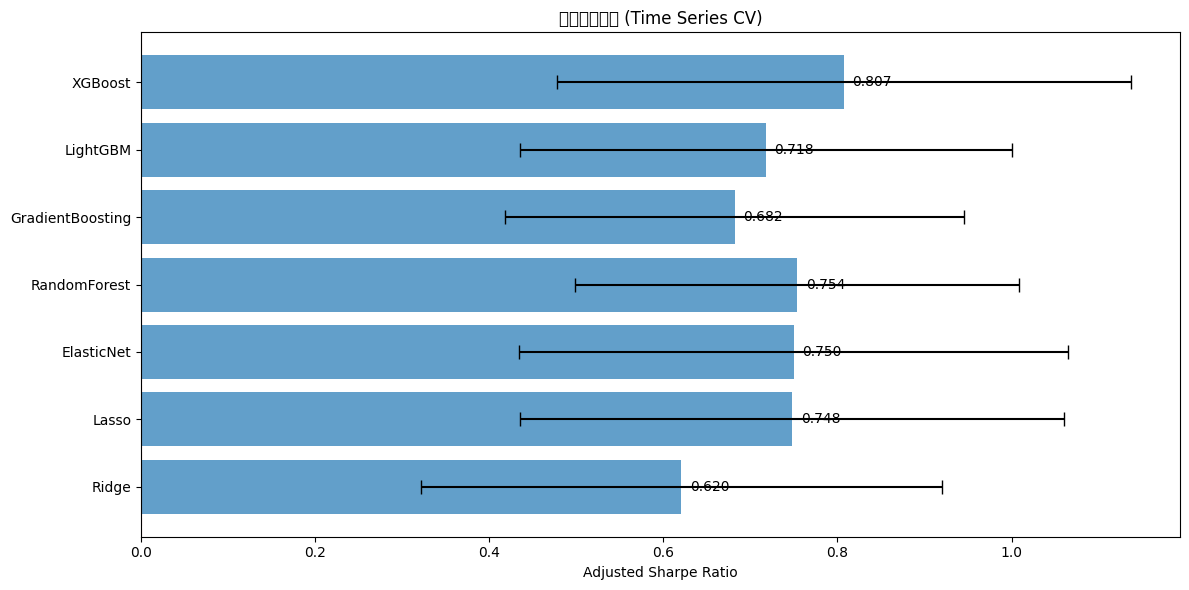

In [32]:
# 可视化模型比较
if results:
    model_names = list(results.keys())
    means = [results[m]['mean'] for m in model_names]
    stds = [results[m]['std'] for m in model_names]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(model_names, means, xerr=stds, capsize=5, alpha=0.7)
    ax.set_xlabel('Adjusted Sharpe Ratio')
    ax.set_title('模型性能比较 (Time Series CV)')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    # 标注数值
    for bar, mean in zip(bars, means):
        ax.text(mean + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{mean:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

## 5. 选择最佳模型并训练

In [33]:
# 选择最佳模型
if results:
    best_model_name = max(results, key=lambda x: results[x]['mean'])
    print(f'最佳模型: {best_model_name}')
    print(f'验证分数: {results[best_model_name]["mean"]:.4f}')
else:
    best_model_name = 'Ridge'
    print('使用默认模型: Ridge')

# 重新创建并训练最佳模型
if best_model_name == 'LightGBM' and HAS_LGB:
    best_model = lgb.LGBMRegressor(n_estimators=200, max_depth=5, random_state=42, verbose=-1)
elif best_model_name == 'XGBoost' and HAS_XGB:
    best_model = xgb.XGBRegressor(n_estimators=200, max_depth=5, random_state=42, verbosity=0)
elif best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1)
elif best_model_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
else:
    best_model = Ridge(alpha=1.0)

# 在全部训练数据上训练
best_model.fit(X_train, y_train)
print(f'\n模型训练完成!')

最佳模型: XGBoost
验证分数: 0.8070

模型训练完成!


## 6. 生成测试集预测

In [34]:
# 处理测试集特征
# 注意：测试集有额外的列
test_feature_cols = [col for col in feature_cols if col in test_df.columns]

# 重新训练特征工程器以处理测试集
X_test = fe.transform(test_df)

# 预测
test_predictions = best_model.predict(X_test)
test_weights = strategy.predict_to_weight(test_predictions)

print(f'预测权重统计:')
print(f'  Min: {test_weights.min():.4f}')
print(f'  Max: {test_weights.max():.4f}')
print(f'  Mean: {test_weights.mean():.4f}')
print(f'  Std: {test_weights.std():.4f}')

预测权重统计:
  Min: 0.6919
  Max: 1.3259
  Mean: 1.0559
  Std: 0.1966


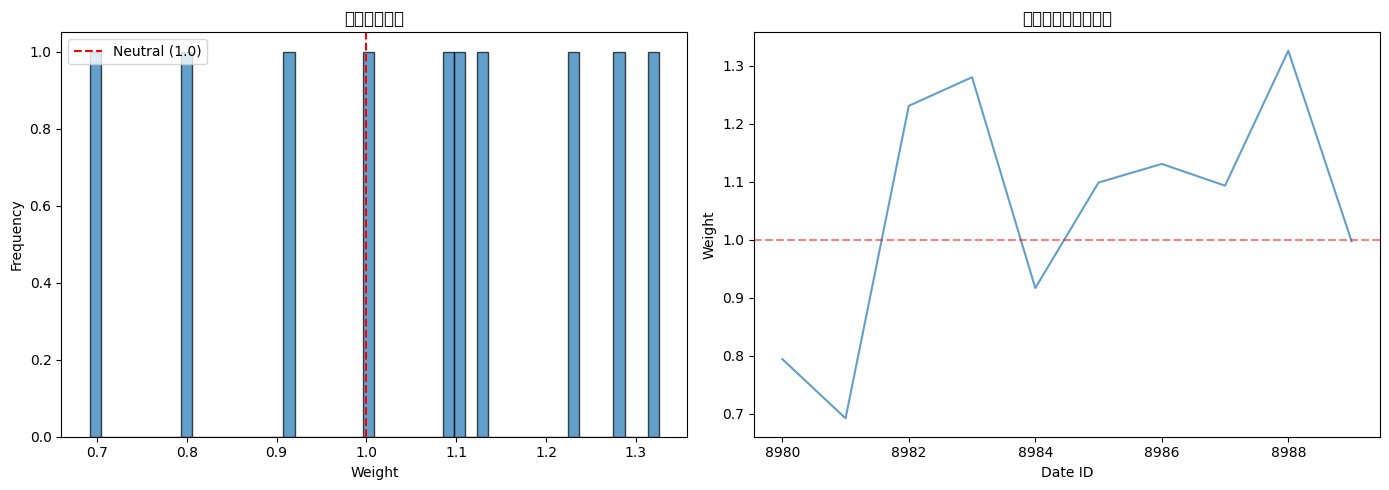

In [35]:
# 可视化预测权重分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 权重分布
axes[0].hist(test_weights, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('预测权重分布')
axes[0].axvline(x=1, color='red', linestyle='--', label='Neutral (1.0)')
axes[0].legend()

# 权重随时间变化
axes[1].plot(test_df['date_id'], test_weights, alpha=0.7)
axes[1].set_xlabel('Date ID')
axes[1].set_ylabel('Weight')
axes[1].set_title('预测权重随时间变化')
axes[1].axhline(y=1, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [36]:
# 创建提交文件
submission = pd.DataFrame({
    'date_id': test_df['date_id'],
    'prediction': test_weights
})

# 确保权重在有效范围内
submission['prediction'] = submission['prediction'].clip(MIN_INVESTMENT, MAX_INVESTMENT)

submission.to_csv('submission.csv', index=False)
print('提交文件已保存为 submission.csv')
print(submission.head(10))

提交文件已保存为 submission.csv
   date_id  prediction
0     8980    0.794056
1     8981    0.691854
2     8982    1.230792
3     8983    1.280123
4     8984    0.916575
5     8985    1.098534
6     8986    1.130636
7     8987    1.093095
8     8988    1.325863
9     8989    0.997398


## 7. 使用评估API计算本地分数

In [37]:
# 在训练数据的最后部分模拟评估
# 注意：公共测试集是训练集最后180天的副本
val_size = 180
val_data = train_df.tail(val_size).copy()

# 获取验证集特征并预测
X_val_final = fe.transform(val_data)
val_predictions = best_model.predict(X_val_final)
val_weights = strategy.predict_to_weight(val_predictions)

# 计算分数
local_score = calculate_adjusted_sharpe(
    val_data['forward_returns'].values,
    val_data['risk_free_rate'].values,
    val_weights
)

print(f'本地验证分数 (最后{val_size}天): {local_score:.4f}')

本地验证分数 (最后180天): 5.7566


In [38]:
# 与简单策略对比
baselines = {
    '全仓持有 (weight=1)': np.ones(val_size),
    '半仓持有 (weight=0.5)': np.ones(val_size) * 0.5,
    '1.5倍杠杆 (weight=1.5)': np.ones(val_size) * 1.5,
    '纯现金 (weight=0)': np.zeros(val_size),
}

print('基准策略对比:')
print('=' * 50)
for name, weights in baselines.items():
    score = calculate_adjusted_sharpe(
        val_data['forward_returns'].values,
        val_data['risk_free_rate'].values,
        weights
    )
    print(f'{name}: {score:.4f}')

print(f'\n我们的模型: {local_score:.4f}')

基准策略对比:
全仓持有 (weight=1): 0.6165
半仓持有 (weight=0.5): 0.5317
1.5倍杠杆 (weight=1.5): 0.4410
纯现金 (weight=0): 0.0000

我们的模型: 5.7566


## 8. 保存模型和配置

In [39]:
import pickle

# 保存模型和特征工程器
with open('model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'feature_engineer': fe,
        'strategy': strategy,
        'feature_cols': feature_cols,
        'valid_start_date': valid_start_date
    }, f)

print('模型已保存为 model.pkl')

模型已保存为 model.pkl


In [40]:
print('\n' + '=' * 60)
print('训练完成总结')
print('=' * 60)
print(f'''
最佳模型: {best_model_name}
本地验证分数: {local_score:.4f}
预测权重范围: [{test_weights.min():.4f}, {test_weights.max():.4f}]
预测权重均值: {test_weights.mean():.4f}

输出文件:
- submission.csv: Kaggle提交文件
- model.pkl: 训练好的模型

下一步:
1. 将notebook上传到Kaggle
2. 运行并提交到竞赛
3. 查看公共排行榜分数
''')


训练完成总结

最佳模型: XGBoost
本地验证分数: 5.7566
预测权重范围: [0.6919, 1.3259]
预测权重均值: 1.0559

输出文件:
- submission.csv: Kaggle提交文件
- model.pkl: 训练好的模型

下一步:
1. 将notebook上传到Kaggle
2. 运行并提交到竞赛
3. 查看公共排行榜分数

